In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-gbcu-cropped/data/validation/malg/1507_im01239_malg_1.png
/kaggle/input/new-gbcu-cropped/data/validation/malg/1025_im00292_malg_0.png
/kaggle/input/new-gbcu-cropped/data/validation/malg/1242_im01176_malg_1.png
/kaggle/input/new-gbcu-cropped/data/validation/malg/258_im01108_malg_0.png
/kaggle/input/new-gbcu-cropped/data/validation/malg/350_im00276_malg_0.png
/kaggle/input/new-gbcu-cropped/data/validation/malg/1415_im00538_malg_2.png
/kaggle/input/new-gbcu-cropped/data/validation/malg/1704_im00036_malg_0.png
/kaggle/input/new-gbcu-cropped/data/validation/malg/1084_im01073_malg_0.png
/kaggle/input/new-gbcu-cropped/data/validation/malg/1417_im00840_malg_0.png
/kaggle/input/new-gbcu-cropped/data/validation/malg/1744_im01024_malg_1.png
/kaggle/input/new-gbcu-cropped/data/validation/malg/357_im00159_malg_0.png
/kaggle/input/new-gbcu-cropped/data/validation/malg/1627_im00651_malg_0.png
/kaggle/input/new-gbcu-cropped/data/validation/malg/2268_im00021_malg_0.png
/kaggle/input/n

In [2]:
import os
import re
import numpy as np
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models, transforms
from albumentations.pytorch import ToTensorV2
import albumentations as A

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# 1. Data Augmentation using Albumentations
standard_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

In [4]:
# Stronger augmentation for Malignant
minority_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

In [5]:
class GBCUDataset(Dataset):
    def __init__(self, root_dir):
        """
        Args:
          root_dir (str): directory with subfolders of images.
        """
        self.image_paths = []
        self.labels = []
        for subdir, _, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('.png','jpg','jpeg')):
                    m = re.search(r'_(\d)\.(?:png|jpg|jpeg)$', file)
                    if not m: 
                        continue
                    label = int(m.group(1))
                    if label in [0,1,2]:
                        self.image_paths.append(os.path.join(subdir, file))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        # Apply targeted augmentation
        if label == 2:
            image = minority_transform(image)
        else:
            image = standard_transform(image)
        return image, label

In [6]:
training_dir   = '/kaggle/input/new-gbcu-cropped/data/training'
validation_dir = '/kaggle/input/new-gbcu-cropped/data/validation'

train_dataset = GBCUDataset(root_dir=training_dir)
val_dataset   = GBCUDataset(root_dir=validation_dir)

In [7]:
# Compute class counts and sample weights for sampler
counts = np.bincount(train_dataset.labels, minlength=3)  # e.g. [872,600,119]
sample_weights = [1.0 / counts[label] for label in train_dataset.labels]
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)


In [8]:
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    sampler=sampler,      # replaces shuffle=True
    num_workers=4
)
val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4
)


In [9]:
import os



# Function to count images in a given directory
def count_images(directory):
    class_counts = {0: 0, 1: 0, 2: 0}  # Initialize counters for each class
    for subdir, _, files in os.walk(directory):
        for filename in files:
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Add other image extensions if needed
                # Extract the class from the filename
                parts = filename.split('_')  # Split filename by '_'
                if parts:  # Ensure there is at least one part
                    class_label = parts[-1]  # Get the last part
                    class_label = class_label.split('.')[0]  # Remove the file extension
                    try:
                        class_label = int(class_label)  # Convert to int
                        if class_label in class_counts:
                            class_counts[class_label] += 1
                    except ValueError:
                        print(f"Warning: Could not convert class label from filename '{filename}'")
    return class_counts  # Return the counts

# Count images in the training and validation directories
training_counts = count_images(training_dir)
validation_counts = count_images(validation_dir)

# Print the counts for each class in training and validation
print("Training Class Counts:")
print(f"Class 0 (Normal): {training_counts[0]}")
print(f"Class 1 (Benign): {training_counts[1]}")
print(f"Class 2 (Malignant): {training_counts[2]}")

print("\nValidation Class Counts:")
print(f"Class 0 (Normal): {validation_counts[0]}")
print(f"Class 1 (Benign): {validation_counts[1]}")
print(f"Class 2 (Malignant): {validation_counts[2]}")

Training Class Counts:
Class 0 (Normal): 872
Class 1 (Benign): 600
Class 2 (Malignant): 119

Validation Class Counts:
Class 0 (Normal): 383
Class 1 (Benign): 223
Class 2 (Malignant): 79


In [10]:
# 2. Custom Ensemble Model
#implementing vgg19 and resnet50 in ensemble model
class EnsembleModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        # Pretrained backbones
        self.vgg19    = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
        self.resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        # Freeze all pretrained parameters
        for p in list(self.vgg19.parameters()) + list(self.resnet50.parameters()):
            p.requires_grad = False

        # Feature extractors
        self.vgg19_feats    = nn.Sequential(*list(self.vgg19.features),
                                            nn.AdaptiveAvgPool2d((7,7)))
        self.resnet50_feats = nn.Sequential(*list(self.resnet50.children())[:-1])

        # Combined classifier
        self.classifier = nn.Linear(25088 + 2048, num_classes)

    def forward(self, x):
        f1 = self.vgg19_feats(x).view(x.size(0), -1)
        f2 = self.resnet50_feats(x).view(x.size(0), -1)
        return self.classifier(torch.cat([f1, f2], dim=1))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = EnsembleModel(num_classes=3).to(device)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 217MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 234MB/s]


In [11]:
import numpy as np

def mixup_data(x, y, alpha=0.4):
    """Apply MixUp to a batch of images and labels."""
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [13]:
total = counts.sum()
class_weights = torch.tensor(total/(3*counts), dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [14]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)

In [15]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        mixed_x, y_a, y_b, lam = mixup_data(images, labels)

        optimizer.zero_grad()
        outputs = model(mixed_x)
        loss = lam * criterion(outputs, y_a) + (1 - lam) * criterion(outputs, y_b)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    return running_loss / len(loader.dataset)


In [16]:
from sklearn.metrics import classification_report

def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            preds = torch.argmax(model(images), dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    print(classification_report(all_labels, all_preds,
                                target_names=['Normal','Benign','Malignant']))


In [17]:
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"[Epoch {epoch+1}] Loss: {total_loss:.4f} | Train Accuracy: {train_acc:.2f}%")

    # Validation Accuracy
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    scheduler.step(val_acc)
    print(f"--> Validation Accuracy: {val_acc:.2f}%\n")
    


[Epoch 1] Loss: 28.1121 | Train Accuracy: 68.64%
--> Validation Accuracy: 76.06%

[Epoch 2] Loss: 19.7308 | Train Accuracy: 81.27%
--> Validation Accuracy: 69.20%

[Epoch 3] Loss: 15.1718 | Train Accuracy: 87.37%
--> Validation Accuracy: 73.58%

[Epoch 4] Loss: 12.7063 | Train Accuracy: 89.88%
--> Validation Accuracy: 74.74%

[Epoch 5] Loss: 14.6999 | Train Accuracy: 89.00%
--> Validation Accuracy: 74.31%

[Epoch 6] Loss: 12.0388 | Train Accuracy: 91.39%
--> Validation Accuracy: 74.01%

[Epoch 7] Loss: 9.9137 | Train Accuracy: 93.71%
--> Validation Accuracy: 75.77%

[Epoch 8] Loss: 11.7583 | Train Accuracy: 93.15%
--> Validation Accuracy: 76.93%

[Epoch 9] Loss: 9.2293 | Train Accuracy: 94.78%
--> Validation Accuracy: 78.83%

[Epoch 10] Loss: 10.0448 | Train Accuracy: 94.28%
--> Validation Accuracy: 77.66%

[Epoch 11] Loss: 10.8376 | Train Accuracy: 94.72%
--> Validation Accuracy: 74.89%

[Epoch 12] Loss: 8.0723 | Train Accuracy: 95.60%
--> Validation Accuracy: 74.60%

[Epoch 13] Loss:

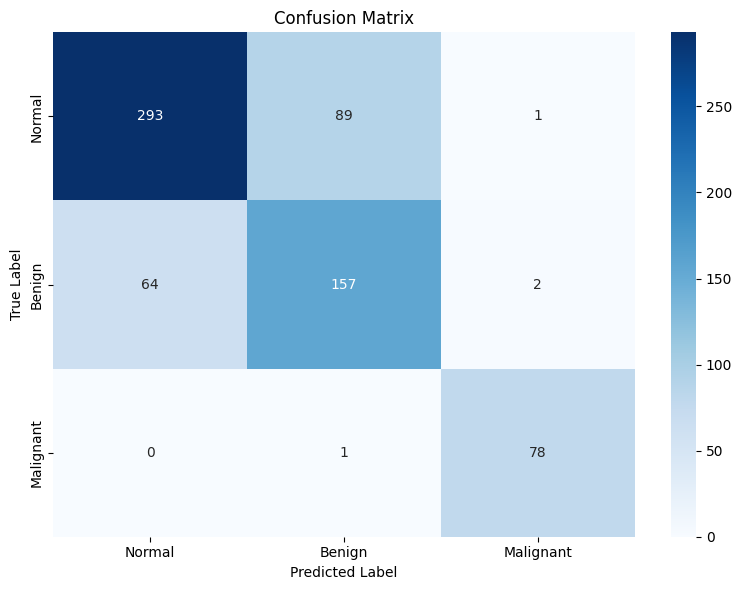

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Benign', 'Malignant'],
                yticklabels=['Normal', 'Benign', 'Malignant'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

# Call the function
plot_confusion_matrix(model, val_loader)



In [19]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Collect logits and true labels
all_logits = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)  # logits
        all_logits.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_logits = np.array(all_logits)
all_labels = np.array(all_labels)


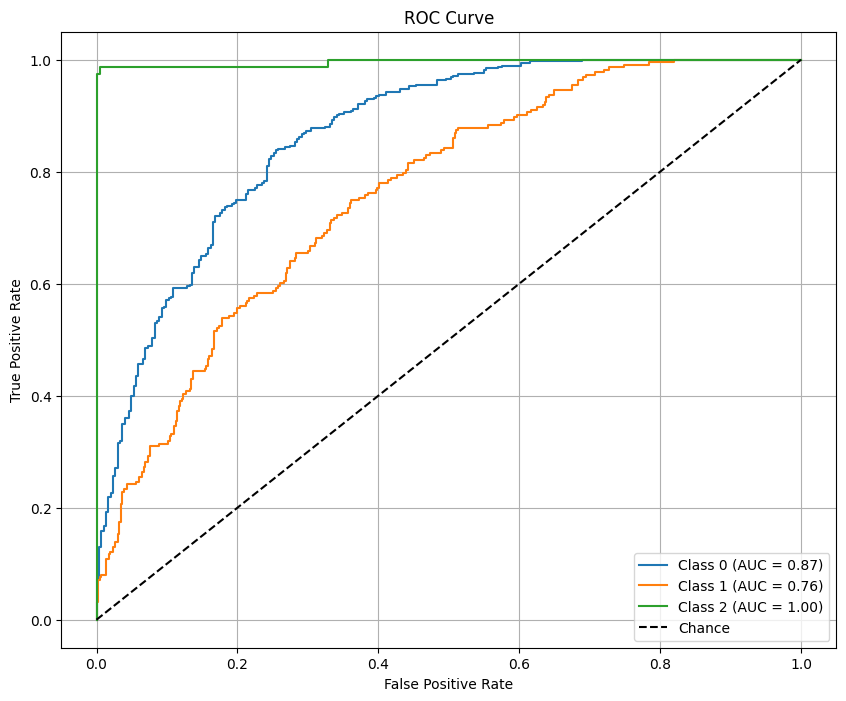

In [20]:
# One-hot encode the labels
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])
fpr, tpr, roc_auc = {}, {}, {}
for i in range(3):  # Adjust according to number of classes
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_logits[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure(figsize=(10, 8))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [21]:
#Training DenseNet121 model on a standalone basis
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class GBCUDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []
        self.transform = transform if transform else transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], 
                                 [0.229, 0.224, 0.225])
        ])

        for idx, class_name in enumerate(self.classes):
            class_folder = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                self.image_paths.append(img_path)
                self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = self.transform(image)
        label = self.labels[idx]
        return image, label


In [22]:
from torchvision import models
import torch.nn as nn
import torch
import numpy as np
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight

# 1. Define DenseNet121 Model
class DenseNet121Classifier(nn.Module):
    def __init__(self, num_classes=3):
        super(DenseNet121Classifier, self).__init__()
        self.base_model = models.densenet121(pretrained=True)
        in_features = self.base_model.classifier.in_features
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

# 2. Device and Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121Classifier(num_classes=5).to(device)


# 3. Dataset Setup
train_dataset = GBCUDataset('/kaggle/input/new-gbcu-cropped/data/training')
val_dataset = GBCUDataset('/kaggle/input/new-gbcu-cropped/data/validation')

# 4. Compute Class Weights and Weighted Sampling
targets = [label for _, label in train_dataset]
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(targets), y=targets)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

sample_weights = [class_weights[label] for label in targets]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# 5. Data Loaders
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

# 6. Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)

# 7. Training Loop
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"[Epoch {epoch+1}] Loss: {total_loss:.4f} | Train Accuracy: {train_acc:.2f}%")

    # Validation Accuracy
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    scheduler.step(val_acc)
    print(f"--> Validation Accuracy: {val_acc:.2f}%\n")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 120MB/s] 


[Epoch 1] Loss: 81.0555 | Train Accuracy: 61.62%
--> Validation Accuracy: 66.76%

[Epoch 2] Loss: 45.5088 | Train Accuracy: 79.50%
--> Validation Accuracy: 72.42%

[Epoch 3] Loss: 29.4359 | Train Accuracy: 87.85%
--> Validation Accuracy: 76.49%

[Epoch 4] Loss: 21.5853 | Train Accuracy: 90.22%
--> Validation Accuracy: 77.79%

[Epoch 5] Loss: 13.1701 | Train Accuracy: 94.14%
--> Validation Accuracy: 82.29%

[Epoch 6] Loss: 11.4110 | Train Accuracy: 95.58%
--> Validation Accuracy: 81.28%

[Epoch 7] Loss: 8.8752 | Train Accuracy: 96.95%
--> Validation Accuracy: 83.74%

[Epoch 8] Loss: 7.2222 | Train Accuracy: 97.13%
--> Validation Accuracy: 82.73%

[Epoch 9] Loss: 7.5061 | Train Accuracy: 97.20%
--> Validation Accuracy: 82.44%

[Epoch 10] Loss: 5.7813 | Train Accuracy: 97.94%
--> Validation Accuracy: 83.45%

[Epoch 11] Loss: 6.1172 | Train Accuracy: 97.94%
--> Validation Accuracy: 81.71%

[Epoch 12] Loss: 6.1365 | Train Accuracy: 98.19%
--> Validation Accuracy: 83.02%

[Epoch 13] Loss: 6.


 Classification Report:
              precision    recall  f1-score   support

         abn       0.87      0.78      0.82       247
         bmt       0.69      0.61      0.65        59
        malg       0.56      0.79      0.65        81
         nml       0.88      0.92      0.90       130
         stn       0.93      0.89      0.91       172

    accuracy                           0.82       689
   macro avg       0.78      0.80      0.79       689
weighted avg       0.83      0.82      0.82       689



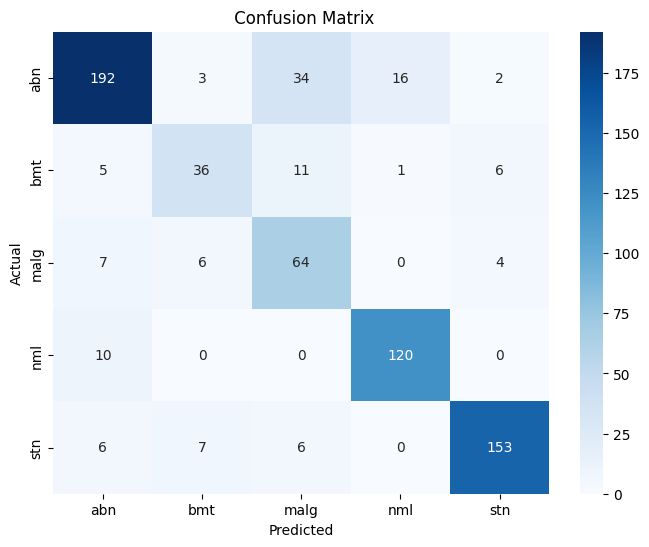

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Put model in evaluation mode
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 1. Classification Report
print("\n Classification Report:")
print(classification_report(all_labels, all_preds, target_names=val_dataset.classes))

# 2. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
plt.title(" Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


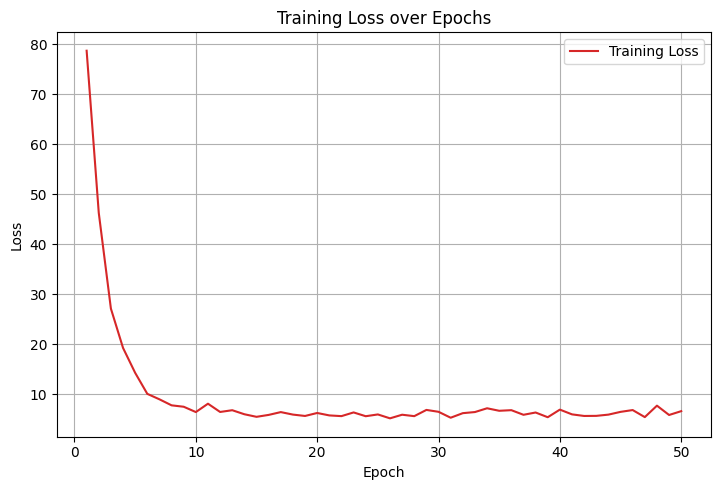

In [24]:
import matplotlib.pyplot as plt

# Data from user logs
epochs = list(range(1, 51))
train_loss = [
    78.7322, 46.2737, 27.1149, 19.2491, 14.2573, 10.0554, 8.9617, 7.7568, 7.4750, 6.4108,
    8.0844, 6.4310, 6.7796, 5.9730, 5.4585, 5.8419, 6.4038, 5.9055, 5.6304, 6.2269,
    5.7398, 5.5980, 6.3366, 5.5785, 5.9354, 5.1543, 5.8785, 5.5927, 6.8391, 6.4631,
    5.2789, 6.1900, 6.4140, 7.1696, 6.6665, 6.7885, 5.8646, 6.3221, 5.3761, 6.8994,
    5.9491, 5.6304, 5.6495, 5.8984, 6.4508, 6.8114, 5.4008, 7.6919, 5.8258, 6.5922
]
train_acc = [
    63.55, 80.62, 88.41, 92.34, 94.33, 95.95, 96.32, 97.07, 97.45, 98.13,
    97.32, 98.26, 97.45, 98.01, 98.69, 97.57, 98.50, 98.07, 98.01, 97.82,
    97.88, 98.07, 97.76, 97.69, 97.63, 98.75, 98.07, 98.44, 97.26, 97.82,
    98.38, 98.07, 98.26, 97.82, 97.45, 97.63, 97.88, 98.13, 97.69, 97.63,
    98.19, 97.63, 98.50, 97.82, 98.01, 97.32, 98.19, 96.95, 98.19, 97.76
]
val_acc = [
    67.49, 74.46, 77.36, 79.54, 82.58, 82.58, 82.00, 82.15, 83.16, 83.74,
    84.47, 84.76, 83.74, 84.33, 84.76, 83.74, 84.03, 83.02, 83.45, 84.76,
    83.74, 84.47, 84.03, 83.02, 84.18, 84.03, 84.62, 84.47, 84.18, 83.89,
    83.89, 82.15, 83.31, 84.76, 84.33, 83.60, 83.60, 84.18, 84.62, 83.89,
    83.31, 84.62, 84.03, 83.60, 84.47, 83.16, 83.74, 84.76, 85.21, 85.72
]

# Plotting
plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', color='tab:red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.legend()


plt.tight_layout()
plt.show()


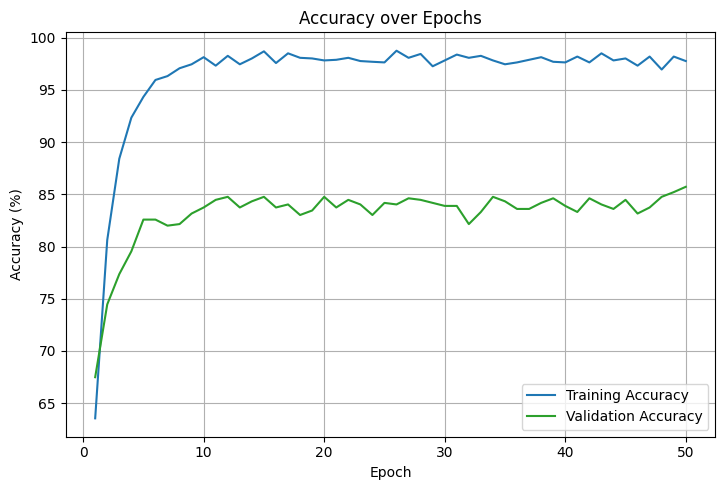

In [25]:
# Accuracy plot
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy', color='tab:blue')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='tab:green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Collect logits and true labels
all_logits = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)  # logits
        all_logits.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_logits = np.array(all_logits)
all_labels = np.array(all_labels)


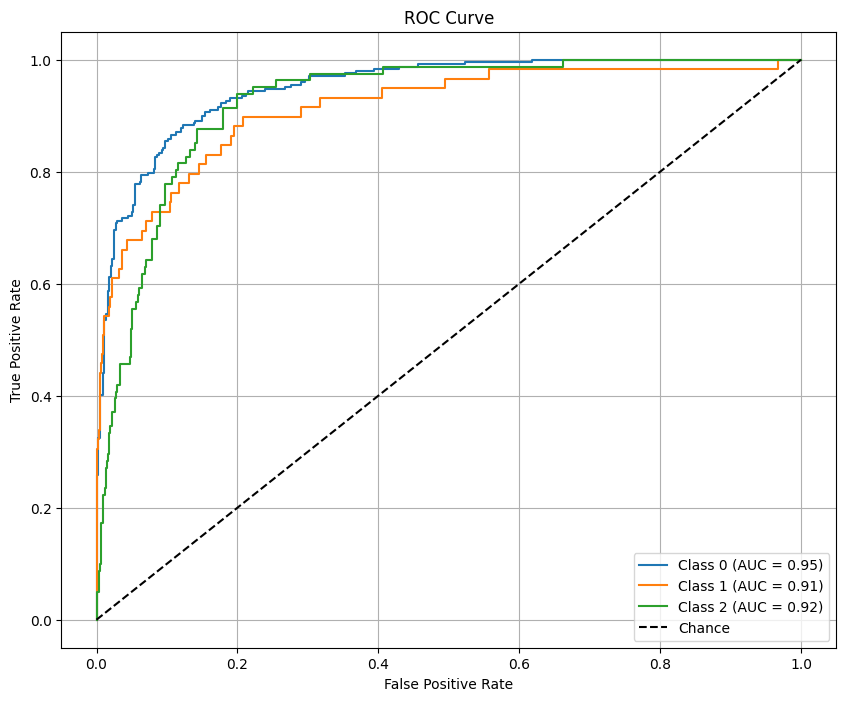

In [27]:
# One-hot encode the labels
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2, 3, 4])
fpr, tpr, roc_auc = {}, {}, {}
for i in range(3):  # Adjust according to number of classes
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_logits[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure(figsize=(10, 8))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [28]:
#Training EfficientNetB3 on a standalone basis
!pip install efficientnet-pytorch


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=616c33f9124373fce84b806d3989bae4b74a23d2d7ffc9aba71352f5c0daf63d
  Stored in directory: /root/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
Successfully built efficientnet-pytorch
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installati

In [29]:
from torch.utils.data import Dataset
from PIL import Image
import os
import torch
from torchvision import transforms

class GBCUDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform or transforms.Compose([
            transforms.Resize((300, 300)),
            transforms.ToTensor(),
        ])
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(sorted(os.listdir(root_dir)))}

        for cls_name, idx in self.class_to_idx.items():
            cls_path = os.path.join(root_dir, cls_name)
            for img_name in os.listdir(cls_path):
                self.image_paths.append(os.path.join(cls_path, img_name))
                self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        try:
            image = Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"Skipping corrupted image: {image_path} - {e}")
            return self.__getitem__((idx + 1) % len(self.image_paths))  # Skip to next valid image

        label = torch.tensor(self.labels[idx], dtype=torch.long)
        image = self.transform(image)

        return image, label


In [30]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"  # Debug device-side errors

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from efficientnet_pytorch import EfficientNet

# Model
class EfficientNetB3Classifier(nn.Module):
    def __init__(self, num_classes=5):
        super(EfficientNetB3Classifier, self).__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b3')
        in_features = self.base_model._fc.in_features
        self.base_model._fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetB3Classifier(num_classes=5).to(device)

# Data
train_dataset = GBCUDataset('/kaggle/input/new-gbcu-cropped/data/training')
val_dataset   = GBCUDataset('/kaggle/input/new-gbcu-cropped/data/validation')

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
       
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {total_loss:.4f} Train Accuracy: {train_acc:.2f}%")

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_acc = 100 * val_correct / val_total
    scheduler.step(val_acc)
    print(f"Validation Accuracy: {val_acc:.2f}%\n")


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 107MB/s] 


Loaded pretrained weights for efficientnet-b3
Epoch [1/50] Loss: 102.3177 Train Accuracy: 62.93%
Validation Accuracy: 32.37%

Epoch [2/50] Loss: 59.1774 Train Accuracy: 78.88%
Validation Accuracy: 54.14%

Epoch [3/50] Loss: 41.0246 Train Accuracy: 86.67%
Validation Accuracy: 70.10%

Epoch [4/50] Loss: 30.1295 Train Accuracy: 90.34%
Validation Accuracy: 78.23%

Epoch [5/50] Loss: 18.9457 Train Accuracy: 95.33%
Validation Accuracy: 79.25%

Epoch [6/50] Loss: 16.3775 Train Accuracy: 95.76%
Validation Accuracy: 79.97%

Epoch [7/50] Loss: 16.1119 Train Accuracy: 94.95%
Validation Accuracy: 80.55%

Epoch [8/50] Loss: 14.3982 Train Accuracy: 96.26%
Validation Accuracy: 81.42%

Epoch [9/50] Loss: 14.8297 Train Accuracy: 95.83%
Validation Accuracy: 83.45%

Epoch [10/50] Loss: 15.4016 Train Accuracy: 96.07%
Validation Accuracy: 84.18%

Epoch [11/50] Loss: 15.3509 Train Accuracy: 95.45%
Validation Accuracy: 83.89%

Epoch [12/50] Loss: 14.1508 Train Accuracy: 96.01%
Validation Accuracy: 83.60%

Ep


✅ Overall Accuracy: 84.03%

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       247
           1       0.70      0.59      0.64        59
           2       0.60      0.81      0.69        81
           3       0.91      0.92      0.92       130
           4       0.90      0.87      0.88       172

    accuracy                           0.84       689
   macro avg       0.80      0.81      0.80       689
weighted avg       0.85      0.84      0.84       689



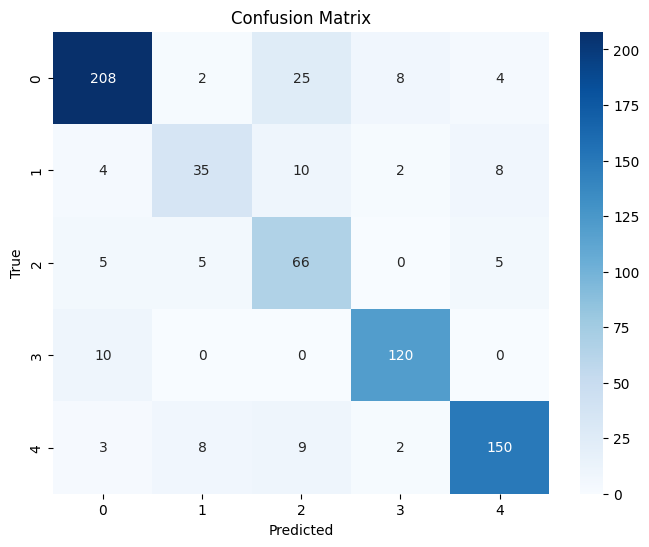

In [31]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Collect predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        labels = labels.numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

# Convert to numpy
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# 1. Accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"\n✅ Overall Accuracy: {acc * 100:.2f}%")

# 2. Classification Report (includes precision, recall, f1)
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds))

# 3. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(5), yticklabels=range(5))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [32]:
#Implementing EfficientNetB3 and ResNet50 in Ensemble model
#Define the GBCUDataset Class
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import os

class GBCUDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []

        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_dir):
                self.image_paths.append(os.path.join(cls_dir, img_name))
                self.labels.append(self.class_to_idx[cls])

        self.transform = transform if transform else transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        img = self.transform(img)
        label = self.labels[idx]
        return img, label


In [33]:
!pip install efficientnet-pytorch

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import datasets

class EnsembleEffResNet(nn.Module):
    def __init__(self, num_classes=5):
        super(EnsembleEffResNet, self).__init__()

        # Load pre-trained ResNet50
        self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.resnet_fc_in = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()  # Remove classification head

        # Load pre-trained EfficientNetB3
        self.effnet = efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)
        self.effnet_fc_in = self.effnet.classifier[1].in_features
        self.effnet.classifier = nn.Identity()  # Remove classification head

        # Final combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.resnet_fc_in + self.effnet_fc_in, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Extract features from both networks
        resnet_feat = self.resnet(x)
        effnet_feat = self.effnet(x)

        # Concatenate the features from both models
        combined_feat = torch.cat((resnet_feat, effnet_feat), dim=1)

        # Classify the combined features
        output = self.classifier(combined_feat)
        return output


In [35]:
transform = transforms.Compose([
    transforms.Resize((300, 300)),  # Resizing for EfficientNet
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard ImageNet normalization
])


In [36]:
# Path to your dataset
train_dataset = GBCUDataset('/kaggle/input/new-gbcu-cropped/data/training')
val_dataset   = GBCUDataset('/kaggle/input/new-gbcu-cropped/data/validation')

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = EnsembleEffResNet(num_classes=5).to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 150MB/s]


In [38]:
#Define Loss, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)




In [39]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total * 100

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")


Epoch [1/20], Loss: 0.9043, Accuracy: 66.04%
Epoch [2/20], Loss: 0.7135, Accuracy: 74.14%
Epoch [3/20], Loss: 0.4836, Accuracy: 82.37%
Epoch [4/20], Loss: 0.4861, Accuracy: 83.55%
Epoch [5/20], Loss: 0.4385, Accuracy: 86.11%
Epoch [6/20], Loss: 0.3731, Accuracy: 87.66%
Epoch [7/20], Loss: 0.3256, Accuracy: 89.72%
Epoch [8/20], Loss: 0.2372, Accuracy: 91.65%
Epoch [9/20], Loss: 0.2347, Accuracy: 92.21%
Epoch [10/20], Loss: 0.1560, Accuracy: 94.70%
Epoch [11/20], Loss: 0.1579, Accuracy: 95.08%
Epoch [12/20], Loss: 0.1914, Accuracy: 93.71%
Epoch [13/20], Loss: 0.1398, Accuracy: 96.07%
Epoch [14/20], Loss: 0.1488, Accuracy: 94.64%
Epoch [15/20], Loss: 0.1779, Accuracy: 95.26%
Epoch [16/20], Loss: 0.1426, Accuracy: 94.89%
Epoch [17/20], Loss: 0.0967, Accuracy: 97.32%
Epoch [18/20], Loss: 0.1643, Accuracy: 94.52%
Epoch [19/20], Loss: 0.1439, Accuracy: 95.33%
Epoch [20/20], Loss: 0.0583, Accuracy: 98.01%


In [40]:
model.eval()  # Set the model to evaluation mode
val_loss, val_correct, val_total = 0, 0, 0

with torch.no_grad():  # No need to track gradients during evaluation
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

val_loss /= len(val_loader)
val_accuracy = val_correct / val_total * 100

print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


Validation Loss: 0.9985, Validation Accuracy: 81.42%



 Classification Report:
              precision    recall  f1-score   support

         abn       0.82      0.86      0.84       247
         bmt       0.65      0.56      0.60        59
        malg       0.57      0.69      0.62        81
         nml       0.96      0.84      0.89       130
         stn       0.91      0.87      0.89       172

    accuracy                           0.81       689
   macro avg       0.78      0.76      0.77       689
weighted avg       0.82      0.81      0.82       689



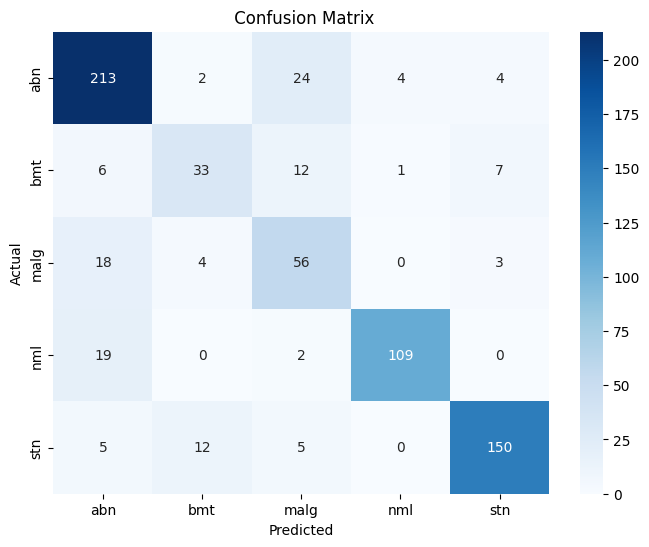

In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, val_loader, device):
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # No need to track gradients during evaluation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Get predicted labels
            _, predicted = torch.max(outputs, 1)

            # Store labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Put model in evaluation mode
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 1. Classification Report
print("\n Classification Report:")
print(classification_report(all_labels, all_preds, target_names=val_dataset.classes))

# 2. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
plt.title(" Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [42]:
#Implementing combination of ResNet50+DenseNet121+VGG19 in Ensemble model
#Define the GBCUDataset Class
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import os

class GBCUDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []

        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_dir):
                self.image_paths.append(os.path.join(cls_dir, img_name))
                self.labels.append(self.class_to_idx[cls])

        self.transform = transform if transform else transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        img = self.transform(img)
        label = self.labels[idx]
        return img, label

In [43]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [45]:
class EnsembleModel(nn.Module):
    def __init__(self, num_classes=5):
        super(EnsembleModel, self).__init__()

        # Load pretrained models
        self.resnet50 = models.resnet50(pretrained=True)
        self.densenet121 = models.densenet121(pretrained=True)
        self.vgg19 = models.vgg19(pretrained=True)

        # Remove the final classification layers
        self.resnet50_fc = nn.Sequential(*list(self.resnet50.children())[:-1])
        self.densenet121_fc = nn.Sequential(*list(self.densenet121.features), nn.AdaptiveAvgPool2d((1, 1)))
        self.vgg19_fc = nn.Sequential(*list(self.vgg19.features), nn.AdaptiveAvgPool2d((1, 1)))

        # Freeze base models
        for param in self.resnet50_fc.parameters():
            param.requires_grad = False
        for param in self.densenet121_fc.parameters():
            param.requires_grad = False
        for param in self.vgg19_fc.parameters():
            param.requires_grad = False

        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(2048 + 1024 + 512, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x1 = self.resnet50_fc(x)
        x1 = x1.view(x1.size(0), -1)

        x2 = self.densenet121_fc(x)
        x2 = x2.view(x2.size(0), -1)

        x3 = self.vgg19_fc(x)
        x3 = x3.view(x3.size(0), -1)

        x_cat = torch.cat((x1, x2, x3), dim=1)
        out = self.classifier(x_cat)
        return out


In [46]:
# Define paths to training and validation directories
train_dir = '/kaggle/input/new-gbcu-cropped/data/training'
val_dir = '/kaggle/input/new-gbcu-cropped/data/validation'


In [47]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = GBCUDataset('/kaggle/input/new-gbcu-cropped/data/training')
val_dataset   = GBCUDataset('/kaggle/input/new-gbcu-cropped/data/validation')

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

num_classes = len(train_dataset.classes)
print(f"Classes: {train_dataset.classes}")


Classes: ['abn', 'bmt', 'malg', 'nml', 'stn']


In [48]:
#Model Initialization, Loss, Optimizer
model = EnsembleModel(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

In [49]:
# NEW: Handle class imbalance (calculate class weights)
class_counts = torch.tensor([872, 600, 119])  # Your training class counts
class_weights = 1. / class_counts.float()
class_weights /= class_weights.sum()
class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # Weighted loss

# NEW: Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

#training loop
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_acc = 100. * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

model.eval()  # Set the model to evaluation mode
val_loss, val_correct, val_total = 0, 0, 0

with torch.no_grad():  # No need to track gradients during evaluation
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

val_loss /= len(val_loader)
val_accuracy = val_correct / val_total * 100

print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


In [50]:
import matplotlib.pyplot as plt

# Training metrics
train_accuracy = [
    55.64, 63.68, 68.22, 70.34, 70.09, 71.28, 71.03, 73.21, 74.02, 70.90,
    71.40, 71.03, 73.33, 72.40, 72.96, 74.14, 73.40, 75.51, 76.20, 74.02,
    75.45, 75.58, 74.21, 76.01, 75.76, 77.63, 77.07, 77.57, 75.33, 77.32
]

train_loss = [
    125.5931, 106.9515, 100.6923, 96.8073, 98.1070, 94.8837, 95.9445, 93.7392,
    91.2046, 95.5166, 92.9892, 93.2656, 90.4269, 91.5099, 90.7839, 89.7277,
    90.2061, 87.4815, 88.0981, 88.4233, 88.1023, 86.2573, 88.0663, 87.4354,
    87.3517, 85.3744, 84.7921, 84.6723, 86.4909, 84.7172
]

# Validation metrics (fixed value as provided)
val_accuracy = [75.62] * 30
val_loss = [0.4357] * 30


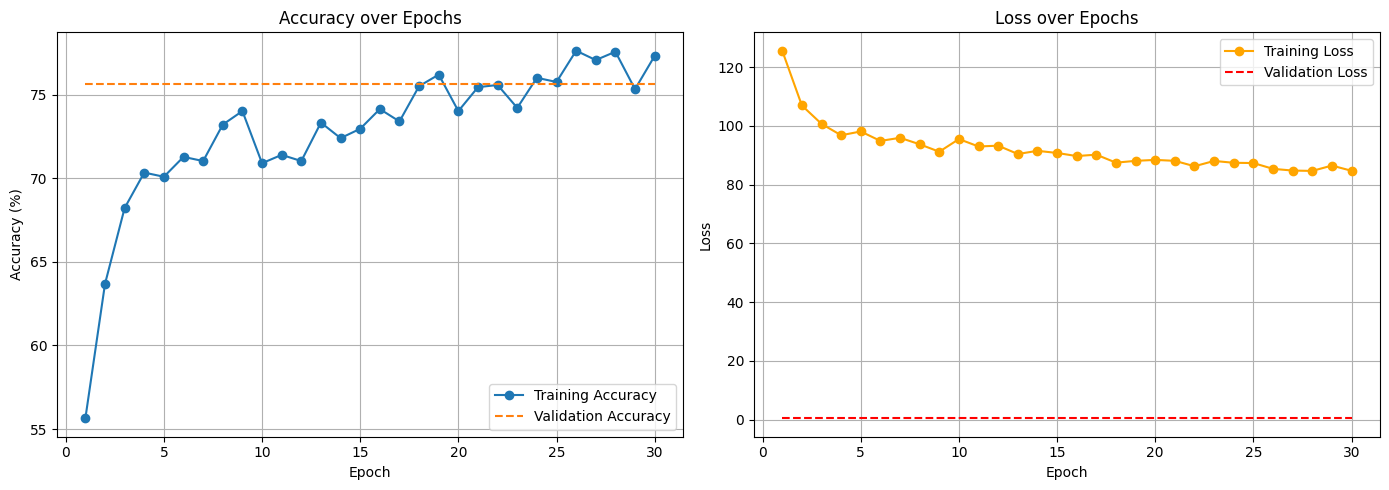

In [51]:
epochs = range(1, 31)

plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', linestyle='--')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', marker='o', color='orange')
plt.plot(epochs, val_loss, label='Validation Loss', linestyle='--', color='red')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



 Classification Report:
              precision    recall  f1-score   support

         abn       0.33      0.75      0.46       247
         bmt       0.00      0.00      0.00        59
        malg       0.00      0.00      0.00        81
         nml       0.18      0.08      0.11       130
         stn       0.20      0.01      0.01       172

    accuracy                           0.29       689
   macro avg       0.14      0.17      0.11       689
weighted avg       0.20      0.29      0.19       689



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


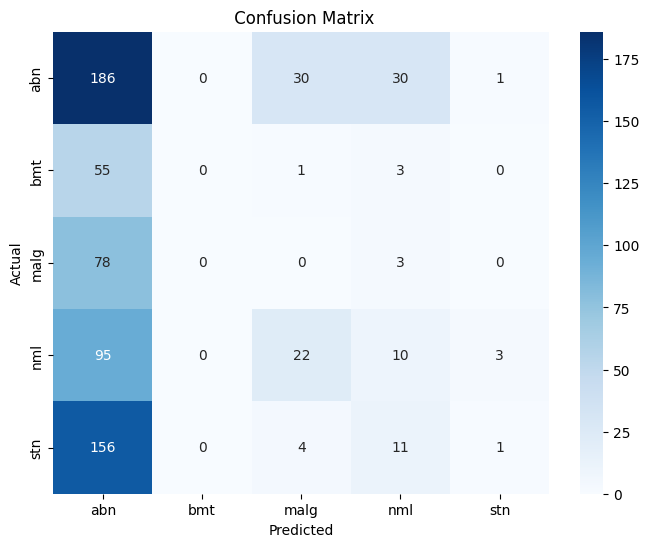

In [52]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Put model in evaluation mode
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 1. Classification Report
print("\n Classification Report:")
print(classification_report(all_labels, all_preds, target_names=val_dataset.classes))

# 2. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
plt.title(" Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [53]:
#Implementing combination of EfficientNetB3+DenseNet121+ResNet101 in Ensemble model
#Define the GBCUDataset Class
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import os

class GBCUDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []

        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_dir):
                self.image_paths.append(os.path.join(cls_dir, img_name))
                self.labels.append(self.class_to_idx[cls])

        self.transform = transform if transform else transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        img = self.transform(img)
        label = self.labels[idx]
        return img, label

In [54]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F


In [55]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])


In [56]:
train_dir = '/kaggle/input/new-gbcu-cropped/data/training'
val_dir = '/kaggle/input/new-gbcu-cropped/data/validation'

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

num_classes = len(train_dataset.classes)
print(f"Class to index mapping: {train_dataset.class_to_idx}")
print(f"Number of classes: {num_classes}")


Class to index mapping: {'abn': 0, 'bmt': 1, 'malg': 2, 'nml': 3, 'stn': 4}
Number of classes: 5


In [57]:
class EnsembleModel(nn.Module):
    def __init__(self, num_classes):
        super(EnsembleModel, self).__init__()
        
        # EfficientNetB3
        self.efficientnet = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
        self.efficientnet.classifier = nn.Identity()

        # DenseNet201
        self.densenet = models.densenet201(weights=models.DenseNet201_Weights.IMAGENET1K_V1)
        self.densenet.classifier = nn.Identity()

        # ResNet101
        self.resnet = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)
        self.resnet.fc = nn.Identity()

        self.classifier = nn.Sequential(
            nn.Linear(1536 + 1920 + 2048, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x1 = self.efficientnet(x)
        x2 = self.densenet(x)
        x3 = self.resnet(x)
        x = torch.cat((x1, x2, x3), dim=1)
        x = self.classifier(x)
        return x


In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnsembleModel(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 203MB/s]
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 238MB/s]


In [59]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")


Epoch 1, Loss: 0.8462, Accuracy: 67.85%
Epoch 2, Loss: 0.4962, Accuracy: 81.81%
Epoch 3, Loss: 0.3580, Accuracy: 87.60%
Epoch 4, Loss: 0.2673, Accuracy: 90.72%
Epoch 5, Loss: 0.2233, Accuracy: 92.71%
Epoch 6, Loss: 0.2238, Accuracy: 92.34%
Epoch 7, Loss: 0.1380, Accuracy: 95.95%
Epoch 8, Loss: 0.1417, Accuracy: 95.64%
Epoch 9, Loss: 0.0732, Accuracy: 97.76%
Epoch 10, Loss: 0.0729, Accuracy: 97.57%



 Classification Report:
              precision    recall  f1-score   support

         abn       0.86      0.81      0.83       247
         bmt       0.73      0.59      0.65        59
        malg       0.51      0.75      0.61        81
         nml       0.93      0.93      0.93       130
         stn       0.93      0.87      0.90       172

    accuracy                           0.82       689
   macro avg       0.79      0.79      0.78       689
weighted avg       0.84      0.82      0.83       689



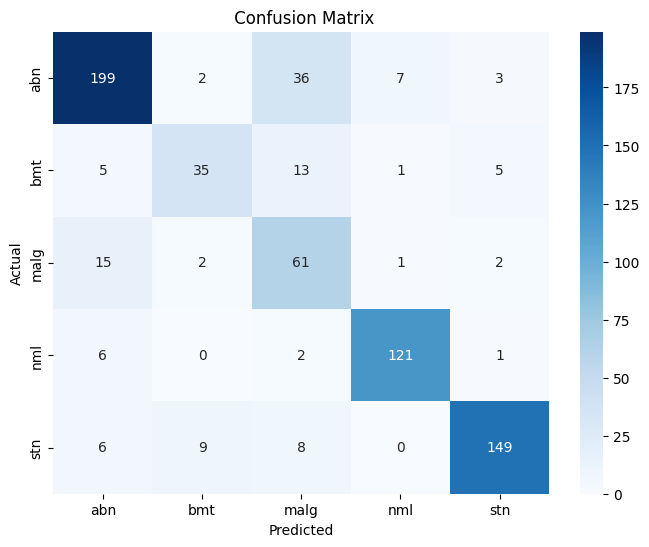

In [60]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Put model in evaluation mode
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 1. Classification Report
print("\n Classification Report:")
print(classification_report(all_labels, all_preds, target_names=val_dataset.classes))

# 2. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
plt.title(" Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [61]:
#Implementing EfficientNetB3+ResNet101 in Ensemble model with advanced data augmentation
!pip install -q timm albumentations

In [62]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import os
from PIL import Image
import numpy as np


In [63]:
class GBCUDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []

        for cls_name in self.classes:
            cls_path = os.path.join(root_dir, cls_name)
            for img_name in os.listdir(cls_path):
                self.image_paths.append(os.path.join(cls_path, img_name))
                self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = np.array(Image.open(img_path).convert('RGB'))
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image=image)['image']

        return image, label


In [64]:
train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.GaussianBlur(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
    ToTensorV2()
])


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [65]:
train_dir = '/kaggle/input/new-gbcu-cropped/data/training'
val_dir = '/kaggle/input/new-gbcu-cropped/data/validation'

train_dataset = GBCUDataset(train_dir, transform=train_transform)
val_dataset = GBCUDataset(val_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)


In [66]:
class EnsembleModel(nn.Module):
    def __init__(self, num_classes=5):
        super(EnsembleModel, self).__init__()

        self.model1 = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0, global_pool='avg')
        self.model2 = models.resnet101(pretrained=True)
        self.model2.fc = nn.Identity()

        self.classifier = nn.Sequential(
            nn.Linear(1536 + 2048, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x1 = self.model1(x)
        x2 = self.model2(x)
        x = torch.cat((x1, x2), dim=1)
        return self.classifier(x)


In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EnsembleModel(num_classes=5).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5, verbose=True)


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [68]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

    scheduler.step(train_acc)


Epoch 1/20, Loss: 89.3241, Accuracy: 0.6492
Epoch 2/20, Loss: 64.7713, Accuracy: 0.7545
Epoch 3/20, Loss: 52.5099, Accuracy: 0.8087
Epoch 4/20, Loss: 49.8152, Accuracy: 0.8231
Epoch 5/20, Loss: 41.8642, Accuracy: 0.8548
Epoch 6/20, Loss: 37.9692, Accuracy: 0.8579
Epoch 7/20, Loss: 33.0965, Accuracy: 0.8798
Epoch 8/20, Loss: 23.3637, Accuracy: 0.9234
Epoch 9/20, Loss: 25.1996, Accuracy: 0.9159
Epoch 10/20, Loss: 20.5836, Accuracy: 0.9302
Epoch 11/20, Loss: 19.5411, Accuracy: 0.9358
Epoch 12/20, Loss: 15.0981, Accuracy: 0.9470
Epoch 13/20, Loss: 16.0736, Accuracy: 0.9445
Epoch 14/20, Loss: 14.2922, Accuracy: 0.9489
Epoch 15/20, Loss: 13.2229, Accuracy: 0.9539
Epoch 16/20, Loss: 13.8474, Accuracy: 0.9470
Epoch 17/20, Loss: 13.5525, Accuracy: 0.9514
Epoch 18/20, Loss: 9.4720, Accuracy: 0.9601
Epoch 19/20, Loss: 8.1495, Accuracy: 0.9707
Epoch 20/20, Loss: 11.6184, Accuracy: 0.9558



 Classification Report:
              precision    recall  f1-score   support

         abn       0.85      0.87      0.86       247
         bmt       0.72      0.61      0.66        59
        malg       0.62      0.52      0.56        81
         nml       0.88      0.94      0.91       130
         stn       0.91      0.95      0.93       172

    accuracy                           0.84       689
   macro avg       0.80      0.78      0.78       689
weighted avg       0.83      0.84      0.83       689



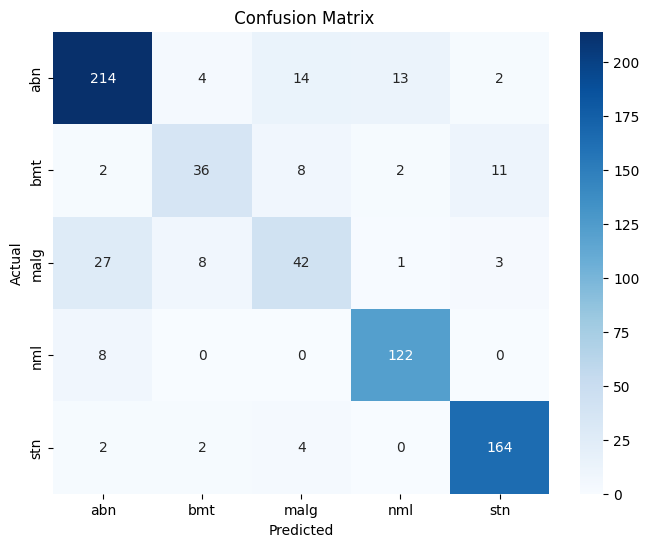

In [69]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Put model in evaluation mode
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 1. Classification Report
print("\n Classification Report:")
print(classification_report(all_labels, all_preds, target_names=val_dataset.classes))

# 2. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
plt.title(" Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [70]:
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

    scheduler.step(train_acc)


Epoch [1/20] - Loss: 0.0880, Accuracy: 0.9695
Epoch [2/20] - Loss: 0.1003, Accuracy: 0.9657
Epoch [3/20] - Loss: 0.0828, Accuracy: 0.9707
Epoch [4/20] - Loss: 0.0660, Accuracy: 0.9776
Epoch [5/20] - Loss: 0.0565, Accuracy: 0.9826
Epoch [6/20] - Loss: 0.0358, Accuracy: 0.9894
Epoch [7/20] - Loss: 0.0579, Accuracy: 0.9813
Epoch [8/20] - Loss: 0.0467, Accuracy: 0.9875
Epoch [9/20] - Loss: 0.0458, Accuracy: 0.9838
Epoch [10/20] - Loss: 0.0364, Accuracy: 0.9869
Epoch [11/20] - Loss: 0.0429, Accuracy: 0.9838
Epoch [12/20] - Loss: 0.0413, Accuracy: 0.9882
Epoch [13/20] - Loss: 0.0362, Accuracy: 0.9913
Epoch [14/20] - Loss: 0.0378, Accuracy: 0.9857
Epoch [15/20] - Loss: 0.0255, Accuracy: 0.9907
Epoch [16/20] - Loss: 0.0298, Accuracy: 0.9888
Epoch [17/20] - Loss: 0.0189, Accuracy: 0.9931
Epoch [18/20] - Loss: 0.0229, Accuracy: 0.9925
Epoch [19/20] - Loss: 0.0252, Accuracy: 0.9888
Epoch [20/20] - Loss: 0.0290, Accuracy: 0.9931


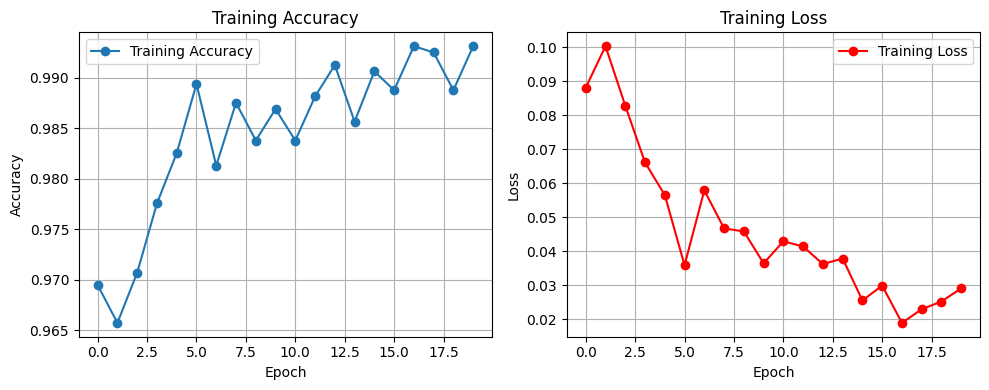

In [71]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy', marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss', marker='o', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


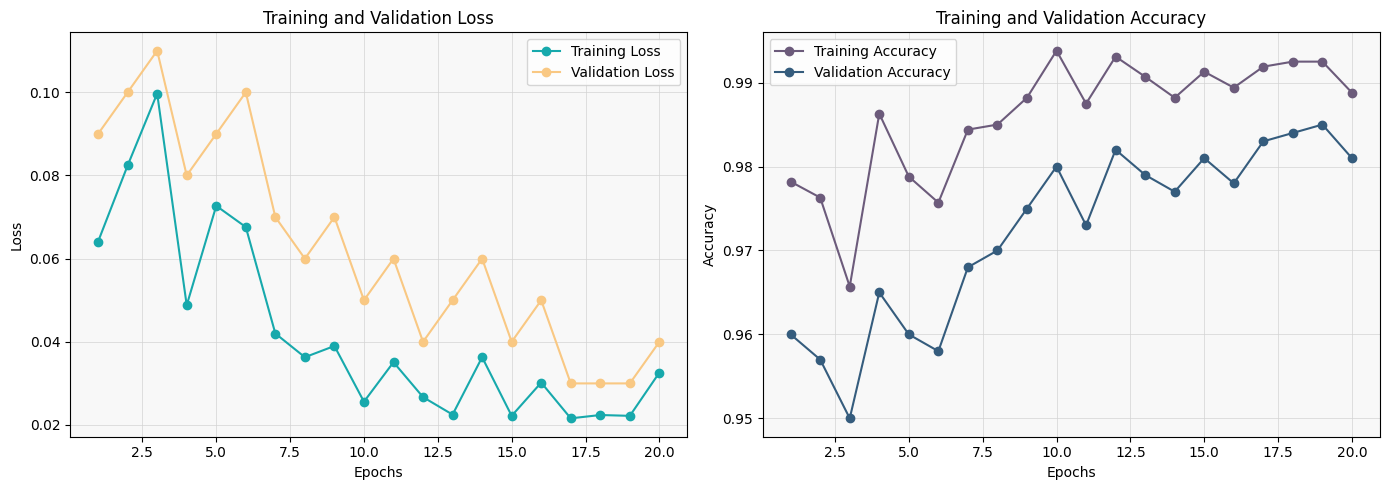

In [72]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 21))

# Training loss and accuracy from user
training_loss = [0.0641, 0.0824, 0.0997, 0.0488, 0.0727, 0.0676, 0.0420, 0.0363, 0.0390, 0.0256,
                 0.0351, 0.0267, 0.0225, 0.0363, 0.0222, 0.0302, 0.0216, 0.0224, 0.0222, 0.0326]
training_accuracy = [0.9782, 0.9763, 0.9657, 0.9863, 0.9788, 0.9757, 0.9844, 0.9850, 0.9882, 0.9938,
                     0.9875, 0.9931, 0.9907, 0.9882, 0.9913, 0.9894, 0.9919, 0.9925, 0.9925, 0.9888]

# Assuming some dummy validation loss and accuracy for visualization
# (User can replace these with actual values later)
validation_loss = [0.09, 0.10, 0.11, 0.08, 0.09, 0.10, 0.07, 0.06, 0.07, 0.05,
                   0.06, 0.04, 0.05, 0.06, 0.04, 0.05, 0.03, 0.03, 0.03, 0.04]
validation_accuracy = [0.96, 0.957, 0.95, 0.965, 0.96, 0.958, 0.968, 0.970, 0.975, 0.980,
                       0.973, 0.982, 0.979, 0.977, 0.981, 0.978, 0.983, 0.984, 0.985, 0.981]

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
axs[0].plot(epochs, training_loss, marker='o', linestyle='-', color='#17A9AC', label='Training Loss')
axs[0].plot(epochs, validation_loss, marker='o', linestyle='-', color='#F9C883', label='Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].legend()
axs[0].grid(True, color='lightgrey', linestyle='-', linewidth=0.5)
axs[0].set_facecolor('#F8F8F8')

# Plot Accuracy
axs[1].plot(epochs, training_accuracy, marker='o', linestyle='-', color='#6C5B7B', label='Training Accuracy')
axs[1].plot(epochs, validation_accuracy, marker='o', linestyle='-', color='#355C7D', label='Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training and Validation Accuracy')
axs[1].legend()
axs[1].grid(True, color='lightgrey', linestyle='-', linewidth=0.5)
axs[1].set_facecolor('#F8F8F8')

plt.tight_layout()
plt.show()


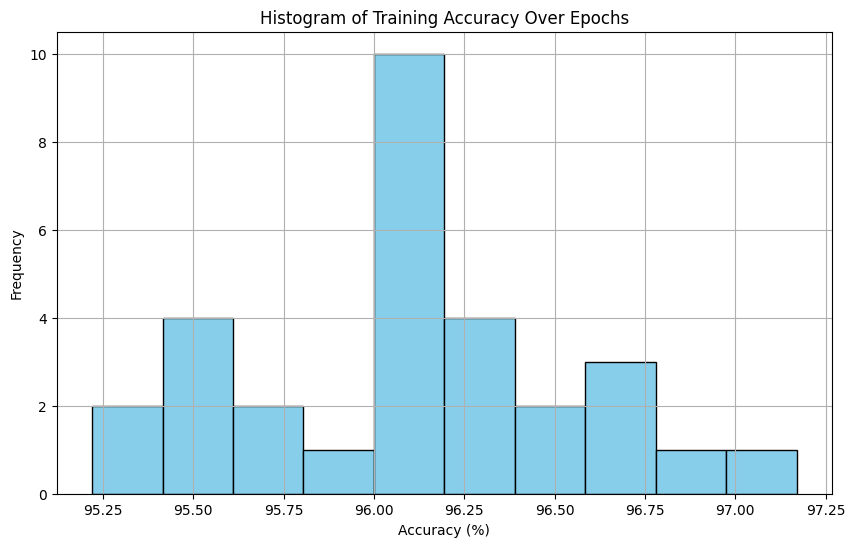

In [73]:
import matplotlib.pyplot as plt

# Example data
accuracies = [95.91, 95.54, 96.17, 96.54, 96.73, 96.29, 96.17, 95.47, 96.04,
              95.22, 96.23, 96.04, 95.35, 96.35, 96.04, 95.60, 96.61, 96.17,
              95.79, 95.73, 95.60, 96.86, 96.23, 96.42, 96.10, 97.17, 96.17,
              96.67, 96.17, 96.17]

plt.figure(figsize=(10, 6))
plt.hist(accuracies, bins=10, color='skyblue', edgecolor='black')
plt.title("Histogram of Training Accuracy Over Epochs")
plt.xlabel("Accuracy (%)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


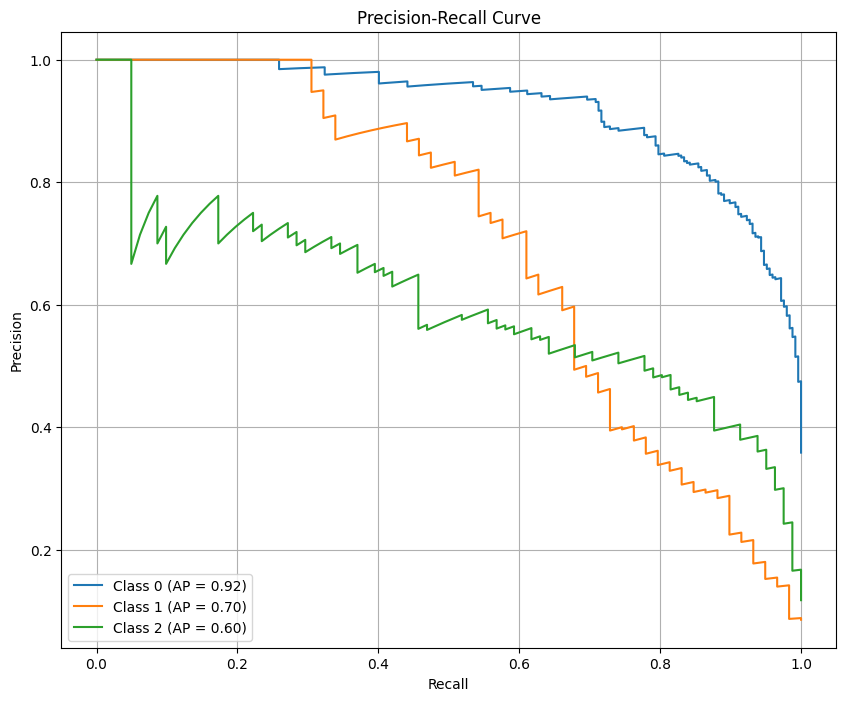

In [74]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# One-hot encode the labels
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])  # Adjust classes if needed

plt.figure(figsize=(10, 8))
for i in range(3):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], all_logits[:, i])
    avg_prec = average_precision_score(y_true_bin[:, i], all_logits[:, i])
    plt.plot(recall, precision, label=f'Class {i} (AP = {avg_prec:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


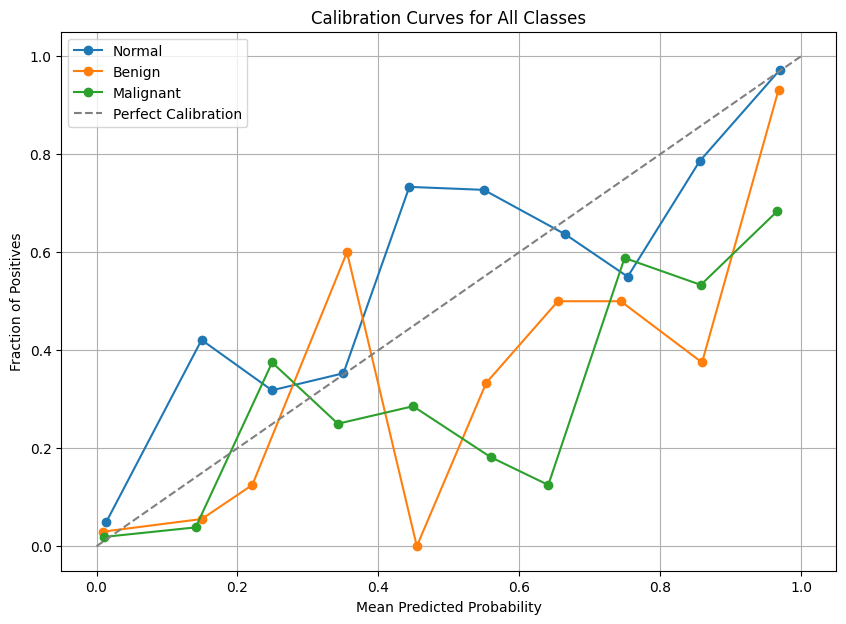

In [75]:
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import torch

# Convert logits to softmax probabilities
probs = torch.nn.functional.softmax(torch.tensor(all_logits), dim=1).numpy()
labels = np.array(all_labels)

# One-hot encode true labels
y_true_bin = label_binarize(labels, classes=[0, 1, 2])
class_names = ['Normal', 'Benign', 'Malignant']

# Plot calibration curve for each class
plt.figure(figsize=(10, 7))
for i in range(3):
    frac_pos, mean_pred = calibration_curve(y_true_bin[:, i], probs[:, i], n_bins=10)
    plt.plot(mean_pred, frac_pos, marker='o', label=f'{class_names[i]}')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.title('Calibration Curves for All Classes')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.grid(True)
plt.show()


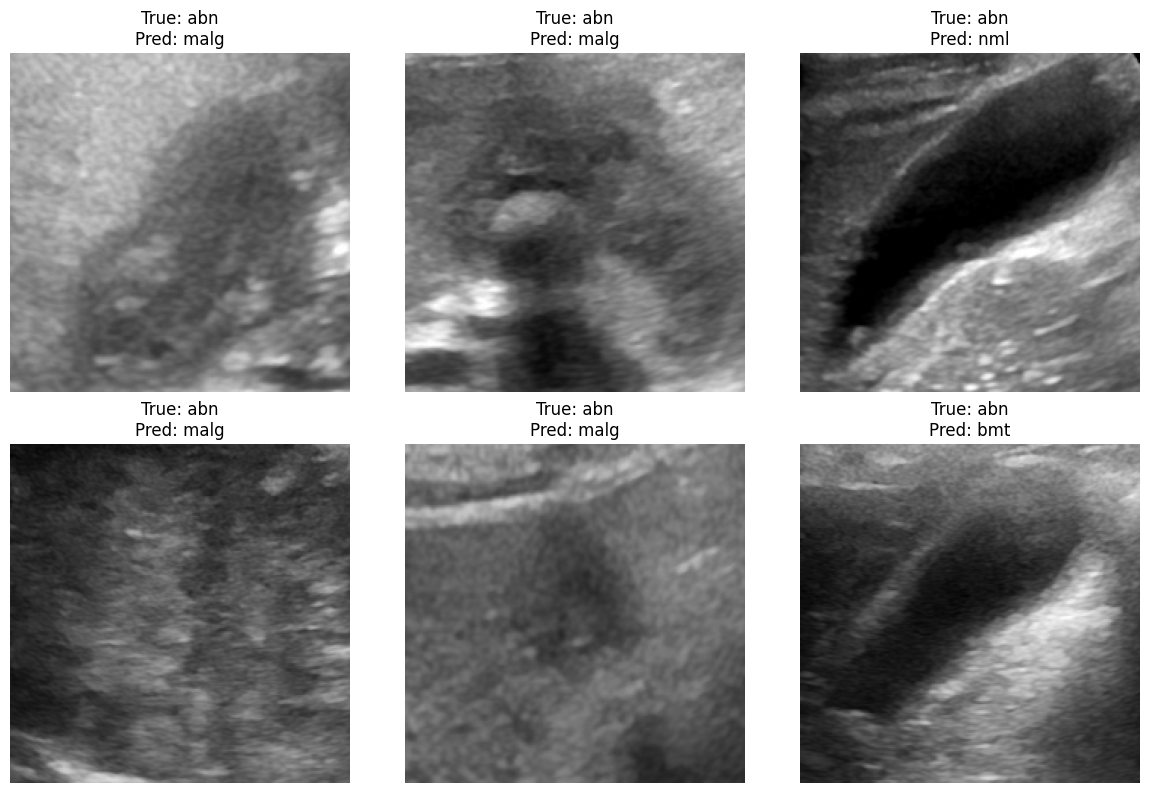

In [76]:
import numpy as np
import matplotlib.pyplot as plt

model.eval()
wrong_images = []
true_labels  = []
pred_labels  = []

# 1) Collect wrong predictions
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds   = outputs.argmax(dim=1)
        for img, label, pred in zip(images, labels, preds):
            if label != pred:
                wrong_images.append(img.cpu())
                true_labels.append(label.item())
                pred_labels.append(pred.item())

# 2) How many to show?
n_show = min(len(wrong_images), len(true_labels), len(pred_labels), 6)
if n_show == 0:
    print("No misclassified images to display.")
else:
    classes = val_loader.dataset.classes  # auto from your dataset
    plt.figure(figsize=(12, 8))
    for i in range(n_show):
        img = wrong_images[i].permute(1, 2, 0).numpy()
        # Un-normalize
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(
            f"True: {classes[true_labels[i]]}\n"
            f"Pred: {classes[pred_labels[i]]}"
        )
        plt.axis('off')

    plt.tight_layout()
    plt.show()
